In [20]:
from fenics import *
import matplotlib.pyplot as plt
import numpy as np

import meshio #--> convert to xdmf if not done already 
msh = meshio.read("fem/deep_notched.msh")
for cell in msh.cells:
    triangle_cells = cell.data

triangle_mesh = meshio.Mesh(points=msh.points[:, :2], cells={"triangle": triangle_cells})
meshio.write("fem/deep_notched.xdmf", triangle_mesh, file_format='xdmf')


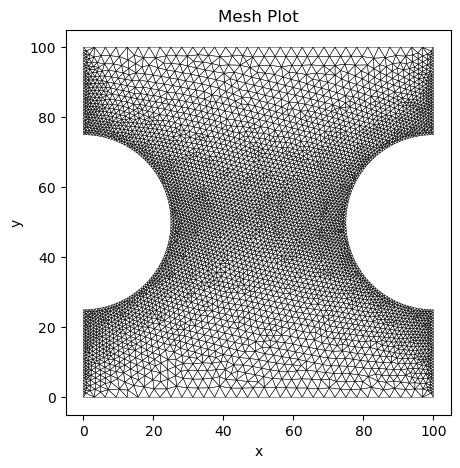

Mesh dimension: 2


In [21]:
# Load the mesh
mesh = Mesh()
with XDMFFile("fem/deep_notched.xdmf") as infile:
    infile.read(mesh)

plot_mesh = True  # Set to True if you want to plot the mesh
if plot_mesh:
    # Extract vertices and cells from the mesh
    vertices = mesh.coordinates()
    cells = mesh.cells()

    # Plot the mesh
    plt.figure(figsize=(5, 5))
    for cell in cells:
        vertices_cell = vertices[cell]
        plt.fill(vertices_cell[:, 0], vertices_cell[:, 1], edgecolor='k', linewidth=0.3, fill=False)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Mesh Plot')
    plt.gca().set_aspect('equal')
    plt.show()

    print("Mesh dimension:", mesh.geometric_dimension())

In [26]:
stress_bc = False
material_type = 'isotropic'  # 'isotropic' or 'orthotropic'

# Define geometry parameters
Lmax = 100.0
Hmax = 100.0

pstress = 50.0

# Material parameters (converted to N/mm^2)
if material_type == 'isotropic':
    E   = 52e3      # GPa->N/mm^2
    nu  = 0.3
    # isotropic plane stress stiffness factors
    def sigma_tensor(u):
        eps = sym(nabla_grad(u))
        return as_tensor([
            [E/(1-nu**2)*(eps[0,0] + nu*eps[1,1]), E/(1+nu)*eps[0,1]],
            [E/(1+nu)*eps[1,0],             E/(1-nu**2)*(eps[1,1] + nu*eps[0,0])]
        ])

elif material_type == 'orthotropic':
    Q11, Q22, Q12, Q66 = 41e3, 10.3e3, 3.1e3, 4e3
    # orthotropic plane stress
    def sigma_tensor(u):
        eps = sym(nabla_grad(u))
        return as_tensor([
            [Q11*eps[0,0] + Q12*eps[1,1],         2*Q66*eps[0,1]],
            [2*Q66*eps[1,0],                 Q12*eps[0,0] + Q22*eps[1,1]]
        ])


# Define boundary condition
V = VectorFunctionSpace(mesh, 'P', 1)

tol = 1E-14

def top_boundary(x, on_boundary):
    return on_boundary and near(x[1], Hmax, tol)

def bottom_boundary(x, on_boundary):
    return on_boundary and near(x[1], 0, tol)


bc1 = DirichletBC(V.sub(0), Constant(0), bottom_boundary)
bc2 = DirichletBC(V.sub(1), Constant(0), bottom_boundary)
bc3 = DirichletBC(V.sub(0), Constant(0), top_boundary)
uy_top = pstress * Hmax / E  if material_type == 'isotropic' else pstress* Hmax / Q22
# uy_top = 1 # 1 mm
bc4 = DirichletBC(V.sub(1), Constant(uy_top), top_boundary)     # uy on top
bc = [bc1, bc2] if stress_bc else [bc1, bc2, bc3, bc4]

#mark top boundary
if stress_bc:
    top = AutoSubDomain(top_boundary)
    boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
    boundaries.set_all(0)
    top.mark(boundaries, 1)
    ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

# Define strain and stress

def epsilon(u):
    return 0.5*(nabla_grad(u) + nabla_grad(u).T)
    # return sym(nabla_grad(u))

# Define variational problem
x = SpatialCoordinate(mesh)
u = TrialFunction(V)
d = u.geometric_dimension()  # space dimension
v = TestFunction(V)
f = Constant((0, 0))

T = Constant((0, pstress))
a = inner(sigma_tensor(u), epsilon(v))*dx

if stress_bc:
    L = dot(f, v)*dx + dot(T, v)*ds(1)
else:
    L = dot(Constant((0.0, 0.0)), v) * dx # No external forces

# Compute solution
u = Function(V)
solve(a == L, u, bc)

tensor_space = TensorFunctionSpace(mesh, 'P', 1)
strain = project(epsilon(u), tensor_space)
stress = project(sigma_tensor(u), tensor_space)
print(f"Uy top: {uy_top:.3e} mm")

Solving linear variational problem.
Uy top: 9.615e-02 mm


Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


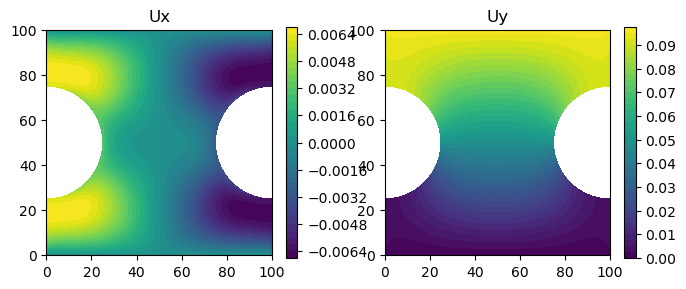

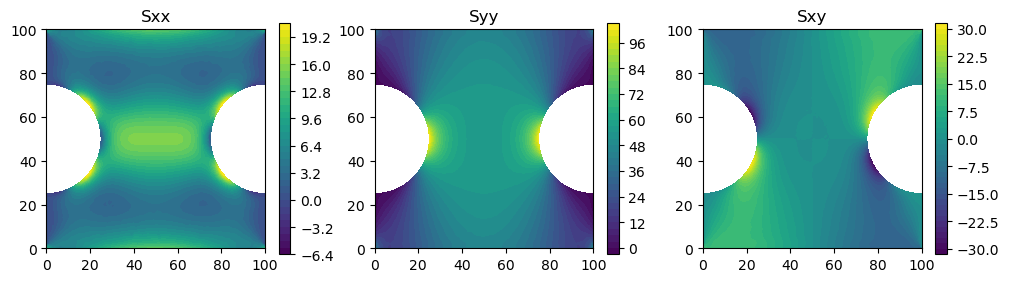

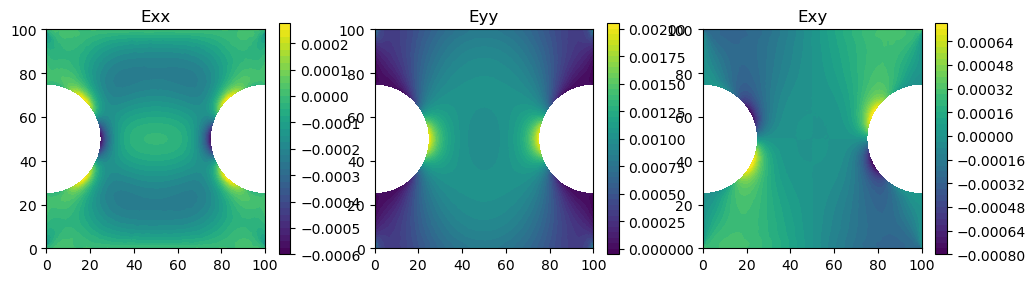

In [27]:
plt.subplots(1,2, figsize=(8, 3))

plt.subplot(121)
im = plot(u[0], mesh=mesh, title='Ux')
plt.colorbar(im)
plt.subplot(122)
im = plot(u[1], title='Uy')
plt.colorbar(im)

plt.subplots(1,3, figsize=(12, 3))
plt.subplot(131)
im = plot(stress[0, 0], title='Sxx')
plt.colorbar(im)
plt.subplot(132)
im = plot(stress[1, 1], title='Syy')
plt.colorbar(im)
plt.subplot(133)
im = plot(stress[0, 1], title='Sxy')
plt.colorbar(im)

plt.subplots(1,3, figsize=(12, 3))
plt.subplot(131)
im = plot(strain[0, 0], title='Exx')
plt.colorbar(im)
plt.subplot(132)
im = plot(strain[1, 1], title='Eyy')
plt.colorbar(im)
plt.subplot(133)
im = plot(strain[0, 1], title='Exy')
plt.colorbar(im)

/tmp/ipykernel_4883/3348841157.py:34: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  im = AX.pcolor(X, Y, C, cmap=colormap,shading='auto')


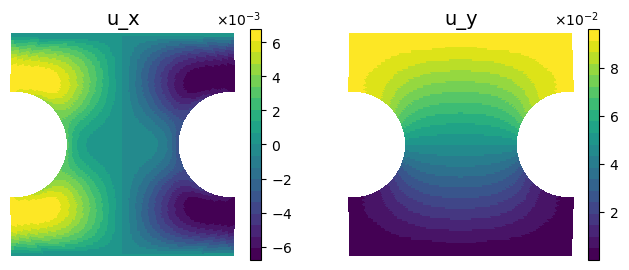

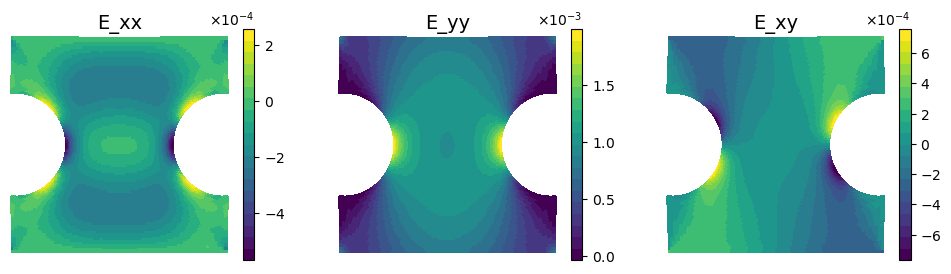

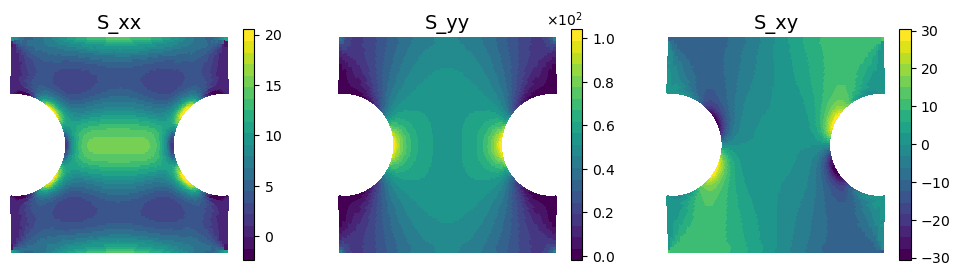

In [48]:
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

# Load geometry mapping
from scipy.ndimage import map_coordinates
nx=60
ny=88
x_max = 100.0
y_max = 100.0

Xp = np.loadtxt(f"./deep_notched_{nx}x{ny}.txt")

# Interpolate mapping
X_map_points = Xp[:, 0].reshape((ny, nx)).T
Y_map_points = Xp[:, 1].reshape((ny, nx)).T

def geometry_mapping(x,y,padding=1e-6):
    x_pos = x/x_max*(nx-1)*(1-2*padding) + padding
    y_pos = y/y_max*(ny-1)*(1-2*padding) + padding

    x_mapped = map_coordinates(X_map_points, [x_pos, y_pos], order=1)
    y_mapped = map_coordinates(Y_map_points, [x_pos, y_pos], order=1)

    return x_mapped, y_mapped


def pcolor_plot(AX, X, Y, C, title,colormap="copper",set_axis = 'off',colorbar=True,**kwargs):
    ## plot the pcolor plot of the given data C on the given axis AX with the given title and optional colorbar limits cmin and cmax
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-2, 2))
    if len(kwargs) == 0:
        im = AX.pcolor(X, Y, C, cmap=colormap,shading='auto')
    else:
        cmin = kwargs["cmin"]
        cmax = kwargs["cmax"]
        im = AX.pcolor(X, Y, C, cmap=colormap, vmin=cmin, vmax=cmax,shading='auto')
    AX.set_aspect("equal", "box")
    AX.axis(set_axis)
    AX.set_title(title, fontsize=14)
    fig.colorbar(im, ax=AX, format=formatter)
    return im

cmap = plt.get_cmap('viridis')
num_colors = 20
color_values = [cmap(i) for i in np.linspace(0, 1, num_colors)]
cmap = ListedColormap(color_values)

n_mesh_x = 100
n_mesh_y = 100

x_plot = np.linspace(0, Lmax, n_mesh_x)
y_plot = np.linspace(0, Hmax, n_mesh_y)
X, Y = np.meshgrid(x_plot, y_plot)

X, Y = geometry_mapping(X, Y)

X_grid = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

u.set_allow_extrapolation(True)
strain.set_allow_extrapolation(True)
stress.set_allow_extrapolation(True)

# Evaluate the solution on the grid
u_val = np.array([u(X_grid[i, :]) for i in range(X_grid.shape[0])])
strain_val = np.array([strain(X_grid[i, :]) for i in range(X_grid.shape[0])])
strain_val = np.array([strain_val[:,0], strain_val[:,3], 0.5*(strain_val[:,1]+strain_val[:,2])]).T
stress_val = np.array([stress(X_grid[i, :]) for i in range(X_grid.shape[0])])
stress_val = np.array([stress_val[:,0], stress_val[:,3], 0.5*(stress_val[:,1]+stress_val[:,2])]).T

# # Plot displacement
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
im = pcolor_plot(ax[0], X, Y, u_val[:,0].reshape(X.shape), "u_x",colormap=cmap)
im = pcolor_plot(ax[1], X, Y, u_val[:,1].reshape(X.shape), "u_y",colormap=cmap)

# # Plot strain
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
im = pcolor_plot(ax[0], X, Y, strain_val[:,0].reshape(X.shape), "E_xx",colormap=cmap)
im = pcolor_plot(ax[1], X, Y, strain_val[:,1].reshape(X.shape), "E_yy",colormap=cmap)
im = pcolor_plot(ax[2], X, Y, strain_val[:,2].reshape(X.shape), "E_xy",colormap=cmap)

# Plot stress
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
im = pcolor_plot(ax[0], X, Y, stress_val[:,0].reshape(X.shape), "S_xx",colormap=cmap)
im = pcolor_plot(ax[1], X, Y, stress_val[:,1].reshape(X.shape), "S_yy",colormap=cmap)
im = pcolor_plot(ax[2], X, Y, stress_val[:,2].reshape(X.shape), "S_xy",colormap=cmap)

plt.show()


In [35]:
print(f"Ux_mean = {np.mean(u_val[:,0]):2e} ; Uy_mean = {np.mean(u_val[:,1]):2e}")
print(f"Exx_mean = {np.mean(strain_val[:,0]):2e} ; Eyy_mean = {np.mean(strain_val[:,1]):2e} ; Exy_mean = {np.mean(strain_val[:,2]):2e}")
print(f"Sxx_mean = {np.mean(stress_val[:,0]):2e} ; Syy_mean = {np.mean(stress_val[:,1]):2e} ; Sxy_mean = {np.mean(stress_val[:,2]):2e}")

Ux_mean = 2.375274e-07 ; Uy_mean = 4.807673e-02
Exx_mean = -1.228045e-04 ; Eyy_mean = 8.430000e-04 ; Exy_mean = -1.849476e-08
Sxx_mean = 7.434030e+00 ; Syy_mean = 4.606621e+01 ; Sxy_mean = -7.397906e-04


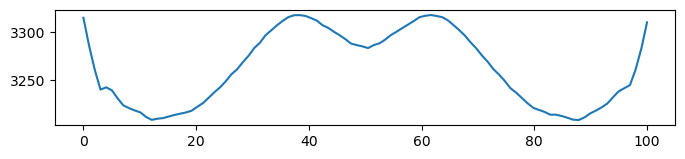

In [50]:
S_yy_fem = stress_val[:, 1].reshape(n_mesh_y, n_mesh_x)
S_yy_integral_fem = np.trapz(S_yy_fem, X, axis=1)

x_width = X[:, -1] - X[:, 0]

# S_yy_integral_fem = np.mean(S_yy_fem, axis=1) * x_width

plt.figure(figsize=(8, 1.5))
plt.plot(y_plot,S_yy_integral_fem, label="Integral stress Syy FEM", linestyle='-')
# plt.plot(y_plot, x_width, label="x_max", linestyle='--', color='black')
# plt.vlines(S_yy_integral_fem.mean(), 0, x_max, color='red', linestyle='--', label="x_max")
# plt.hlines(pstress, 0, y_max, color='red', linestyle='--', label="x_max")
# plt.ylim(0.5, 1.25)  # Set the minimum and maximum y-axis values
# plt.fill_betweenx([0.9, 1.1], 0, 1, color='grey', alpha=0.6)


In [36]:
# Save solution 
solution_name = f"{material_type}_{n_mesh_x}x{n_mesh_y}{'_S_bc' if stress_bc else ''}.dat"
np.savetxt(f"fem/{solution_name}", np.hstack((X_grid, u_val, strain_val, stress_val)), delimiter=' ')

In [37]:
from scipy.interpolate import RegularGridInterpolator

# Load solution
data = np.loadtxt("fem/isotropic_100x100.dat")
X_val = data[:, :2]
u_val = data[:, 2:4]
stress_val = data[:, 7:10]

solution_val = np.hstack((u_val, stress_val))

# Interpolate solution
x_grid = np.linspace(0, x_max, n_mesh_x)
y_grid = np.linspace(0, y_max, n_mesh_y)

interpolators = []
for i in range(solution_val.shape[1]):
    interp = RegularGridInterpolator((x_grid, y_grid), solution_val[:, i].reshape(n_mesh_y, n_mesh_x).T)
    interpolators.append(interp)

solution_fn = lambda x, y: np.array([interp((x, y)) for interp in interpolators]).T

/tmp/ipykernel_4883/3348841157.py:34: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  im = AX.pcolor(X, Y, C, cmap=colormap,shading='auto')


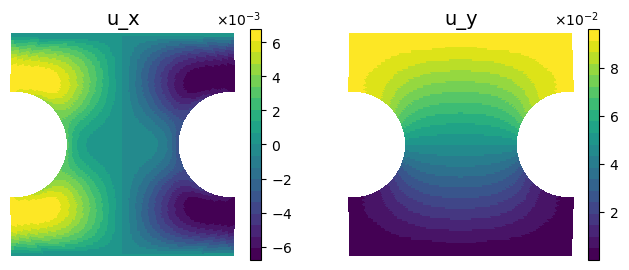

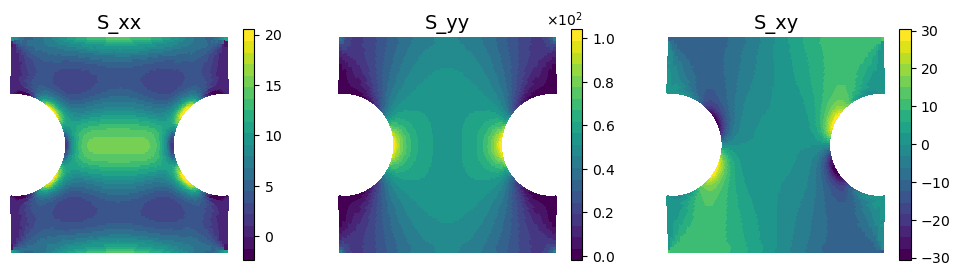

In [38]:
# Check interpolation
x_plot = np.linspace(0, Lmax, n_mesh_x)
y_plot = np.linspace(0, Hmax, n_mesh_y)
X, Y = np.meshgrid(x_plot, y_plot)
X_mapped, Y_mapped = geometry_mapping(X, Y)

X_grid = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

solution_plot = solution_fn(X_grid[:, 0], X_grid[:, 1])

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
im = pcolor_plot(ax[0], X_mapped, Y_mapped, solution_plot[:,0].reshape(X.shape), "u_x",colormap=cmap)
im = pcolor_plot(ax[1], X_mapped, Y_mapped, solution_plot[:,1].reshape(X.shape), "u_y",colormap=cmap)

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
im = pcolor_plot(ax[0], X_mapped, Y_mapped, solution_plot[:,2].reshape(X.shape), "S_xx",colormap=cmap)
im = pcolor_plot(ax[1], X_mapped, Y_mapped, solution_plot[:,3].reshape(X.shape), "S_yy",colormap=cmap)
im = pcolor_plot(ax[2], X_mapped, Y_mapped, solution_plot[:,4].reshape(X.shape), "S_xy",colormap=cmap)


In [50]:
print(f"Ux_mean = {np.mean(solution_plot[:,0]):2e} ; Uy_mean = {np.mean(solution_plot[:,1]):2e}")
print(f"Sxx_mean = {np.mean(solution_plot[:,2]):2e} ; Syy_mean = {np.mean(solution_plot[:,3]):2e} ; Sxy_mean = {np.mean(solution_plot[:,4]):2e}")

Ux_mean = 2.557432e-10 ; Uy_mean = 3.326402e-06
Sxx_mean = 1.851367e-01 ; Syy_mean = 1.392225e+00 ; Sxy_mean = -1.644858e-05


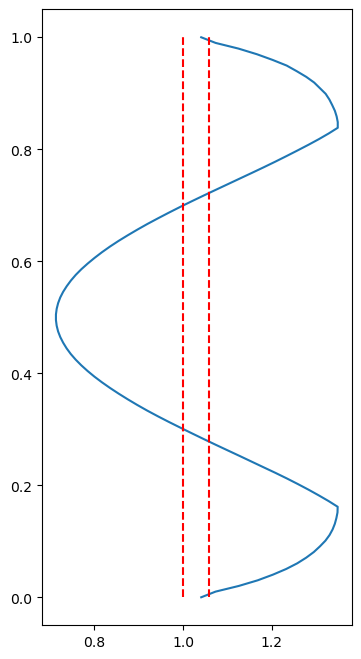

In [56]:
S_yy_fem = solution_plot[:, 3].reshape(n_mesh_y, n_mesh_x).T
S_yy_integral_fem = np.trapz(S_yy_fem, X_mapped, axis=1)
# S_yy_integral_fem = np.mean(S_yy_fem, axis=1)
plt.figure(figsize=(4, 8))
plt.plot(S_yy_integral_fem, y_grid, label="Integral stress Syy FEM", linestyle='-')
plt.vlines(S_yy_integral_fem.mean(), 0, x_max, color='red', linestyle='--', label="x_max")
plt.vlines(pstress, 0, x_max, color='red', linestyle='--', label="x_max")
